In [2]:
import state_dicts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from evaluation_functions import *

\begin{align*}
    \textit{Final Project}
\end{align*}

\begin{align*}
    \text{Hannes Caesar}
\end{align*}

# Introduction

# MD simulation and data generation

In the following, the simulation of alanine dipeptide (Ac-Ala-NHCH3), using the free software package gromacs is described. The simulation was carried out at 300 K in a water filled, cubic simulation box. The simulation was run for total time of t_sim = 5ns, using a time step of dt=0.002 and the Amber ff99SB*-ILDN force field. Writing out the coordinates the .xtc file every 100 steps, the resulting trajectory for the analysis has a temporal resolution of 5 frames/ns. 

Consequently, the total amount of steps was $nsteps = \frac{t_{sim}}{dt} = 2.5\cdot10^{6}$.

Together with the Task sheet the files 
* `ad.pdb` : protein data bank coordinate file of AD
* `MD.mdp` : molecular dynamics parameter file, containing the necesseary parameters for the MD simulation
* `SD.mdp` : molecular dynamics parameter file, containting the necesseary parameters for the steepest descent minimization  

were provided.  
The file preparations and up until the final MD simulation is described in the following 7 steps. (Reocurring flags are not described several times):

1. First, the .pdb file is read and hydrogen atoms are added to the molecules. A structure file of the .gro format and a topology file are created, for which a force field and a water model need to be selected.  

   **gmx pdb2gmx -f ad.pdb -o ad.gro -p ad.top**
    * -f : specifies the input file
    * -o : specifies the output file
    * -p : specifies the topology file  
    
   After excecuting the above command, you get prompted to select a force field. The force field Amber ff99SB*-ILDN (AMBER99SB-ILDN) (#6) is chosen. Then the static water model TIP3P (#1) is chosen. 
    
2. In the second step, the peptide is centered in a cubic simulation box and aligned with its principal axes along the coordinate axes.  

    **gmx editconf -bt cubic -f ad.gro -c -princ -d 0.6 -o ad_box.gro**
    
    * -bt : define box geometry
    * -c : puts geometric center of molecule at (0,0,0) (redundant, because "-d" implies "-c")
    * -princ : aligns principal axes of molecule along the coordinate axes.
    * -d : adjusts system dimension such that the shortest distance between the molecule and the box is -d  
   
   In the output structure file `ad_box.gro`, the box dimension was found to be $1.91896\text{nm}$, which is more than two times the cutoff radius $r_{vdw}=0.9\textit{nm}$. 
3. Afterwards the box is filled with water and the topology file `ad.top` is updated. 

    **gmx solvate -cp ad_box.gro -cs -o ad_box_water.gro -p ad.top**
    * -cp : input coordinate file, used as the **solvate**. 
    * -cs : input **solvent** file. default is SPC (Simple PointCharge water)

4. To prepare a .tpr file, whis is later going to be used for a simulation, the `grompp` comand is used. It reads in a topology file together with the coordinate file and the relevant MD parameter. First, the previously generated coordinate file `ad_box_water.gro` is read to prepare a run input file for a steepest descent minimization of the atom positions.

    **gmx grompp -f SD.mdp -c ad_box_water.gro -p ad.top -o ad_water_SDmin.tpr**
    * -c : coordinate file
 
5. To minimize the energy a short simulation is run. All relevant information are contained in the previuously generated file `ad_water_SDmin.tpr`, which can be used as the input file for the **mdrun** command. 

   **gmx mdrun -v -deffnm ad_water_SDmin**
   
   * -v : verbose(show more information) or in gromacs' words: "Be loud and noisy."
   * -deffnm : sets file name (without extension) for all file options (inputs/outputs)
   
6. In analogy to steps (4) and (5), in steps (6) and (7), a .tpr file is generated with **gromp**, which is then used as an input file for the MD simulation. The main difference is, that the coordinate file for the **grompp** command contains the coordinates after SD minimization and the parameters for the simulations are the ones from `MD.mdp`. 

    **gmx grompp -f SD.mdp -c ad_box_water.gro -p ad.top -o ad_water_SDmin.tpr** 
    
    
    
7. **gmx mdrun -v -deffnm ad_water_SDmin**

## Calculation of dihedral angles 

Below is an image of the investigated alanine dipetide, taken from the molecular visualisation program *VMD*. The relevant atoms as well as the two dihedral angles are labelled.

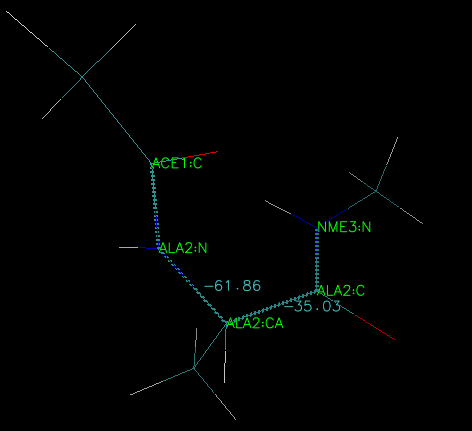

In [1]:
from PIL import Image
Image.open('Dihedral_VMD_AD.png')

A dihedral angle is the angle between to intersecting planes. To calculate such an angle in a molecule, two sets of each 3 atoms need to be specified, where two atoms of both sets are identical and the other ones are different. With these two sets two planes are constructed and an angle between them is then defined via their surface normals. Since two atoms of the sets are the same, a change of the dihedral angle can be seen as a rotation around the intersection line of the two planes. This rotational is therefore defined by the line that connects the two common atoms of the two sets.  

In proteins, $\Phi$ and $\Psi$ form a pairs of dihedral angles along the backbone chain. Here the rotational axis of $\Phi$ is defined as the connecting line between a $C_\alpha$ atom and its neighbouring nitrogen ($N$)atom. The rotational axis of $\Psi$ is the connecting line between $C_\alpha$ and the neighbouring carbon ($C$) atom of the backbone chain. The AD molecule has only one pair (psi,phi) of dihedrals, shown in the image above.

To calculate dihedral angles using the gromacs command **gmx angle**, the index file need to contain groups with 4 indices. These 4 atom indices specifiy the two planes, as described above. The first 3 entries are the set of atoms for the first plane and the last 3 entries are the set of atoms for the second plane. So in order to calculate both $\Phi$ and $\Psi$, and index file with two groups needs to be created.  
The atom indices of the labelled atoms are (left to right) as shown above are:$[5, 7, 9, 15, 17]$  
Therefore the two groups in the index `dihedral_ndx` are defined as follows:  
\[ Phi \]  
5 7 9 15  

\[ Psi \]   
7 9 15 17  

With this, the following command was used to generate two .xvg files containing the evolution of the respective angle. 
**gmx angle -f ad_water_MD.xtc -n dihedral_idx.ndx -type dihedral -ov ad_angle_PHI/PSI.xvg**
* -f : xtc file contains the coordinates of the system at each point of the MD trajectory
* -n : index file with the two index groups
* -type : type of angle which shall be calculated
* -ov : output file 


## Ramachandran plot

Due to the geometry of petides and larger protein structures not all possible combinations of phi and psi are energetically favourable. A Ramachandran plot is a way of visualizing low energy states by plotting occupation of the whole (periodic) phi-psi space. Energetically low regions will be higher populated when compared to energetically higher regions. 

Below, the two xvg files are read into a pandas dataframe and the values are extracted into a numpy array. Gromacs gives angles in degrees. The angle values (in the second column) are converted to radians. 

In [3]:
path_phi = 'simulation_data/ad_angle_PHI.xvg'
path_psi = 'simulation_data/ad_angle_PSI.xvg'
# read in the files for psi and phi
psi_raw = pd.read_csv(path_psi, header=None, skiprows=range(17), sep='\s+')
phi_raw = pd.read_csv(path_phi, header=None, skiprows=range(17), sep='\s+')
# change representation of angles to radians and get values of df
psi = psi_raw.values
psi[:, 1] *= 2*np.pi/360
phi = phi_raw.values
phi[:, 1] *= 2*np.pi/360


# Markov state Model 

General nice info on markov state(more than in introduction. 


## State definitions

In order to generate a MSM, the time evolutions of $\phi$ and $\psi$ need to be combined to obtain a trajectory of states, $s(t)$. Therefore the $\phi$/$\psi$-plane, as shown above, is divided into rectangles such that each point in the plane can be mapped to one of the three states. The state trajectory $s(t)\in{1,2,3}$ is then defined so that for each point in time it contains the state, the system was in at that time.
$s(t)$ could look something like this:
\begin{align*}
    s(t) = 
    \left[
        \begin{array}{cc}
            t_1 & 1\\
            t_2 & 3\\
            t_3 & 3\\
            \cdot & \cdot\\
            \cdot & \cdot\\
            \cdot & \cdot\\
            t_N & 2
        \end{array}
    \right]
\end{align*}


## Transition matrices
The basic concept (???? vllt besser: geht das immer? oder wann geht das, dass man MSM anwendet?) of a Markov State Model ((as described above??)), is two describe the time evolution of the system as transitions between well defined states. The probabilities of these transitions are defined by transition matrices. Given a probability vector 
$\vec{p}(t) = 
    \left[
        \begin{array}{cc}
            p_1(t)\\
            p_2(t)\\
            p_3(t)\\
        \end{array}
    \right]   
$
with $\sum_ip_i = 1$, at a time t, a transition matrix $T(\tau)$ can be used. 

###### Formulars:
\begin{equation}
    N_{ij}(\tau) = \sum_{t=1}^{N-\tau}\delta_{s(t),i}\delta_{s(t+\tau),j}
\end{equation}

\begin{align}
    N(\tau) =
    \left( 
        \begin{array}{ccc}
               N_{11}(\tau)  & N_{12}(\tau) & N_{13}(\tau) \\
               N_{21}(\tau)  & N_{22}(\tau) & N_{23}(\tau)\\
               N_{31}(\tau)  & N_{32}(\tau) & N_{33}(\tau)\\
        \end{array}
    \right)
\end{align}


\begin{align}
    T(\tau) =
    \left( 
        \begin{array}{ccc}
               P_{11}(\tau)  & P_{12}(\tau) & P_{13}(\tau) \\
               P_{21}(\tau)  & P_{22}(\tau) & P_{23}(\tau)\\
               P_{31}(\tau)  & P_{32}(\tau) & P_{33}(\tau)\\
        \end{array}
    \right)
\end{align}

$P_{ij} = \frac{N_{ij}(\tau)}{\sum_{j=1}^{3}N_{ij}(\tau)}$



\begin{equation}
    t^{impl}(\tau) = - \frac{\tau}{ln(\lambda_2(\tau)}
\end{equation}